<img src='img/banner.png' align='right' width='100%'></img>

<div class="alert alert-block alert-success">
<b>PREREQUISITE </b><br>
    
For smooth experience some actions are needed:
* It is expected for user to be familiar with Python.
* It is expected, that **ETFVC** product data is downloaded from [LSA SAF data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/EPS/ETFVC/NETCDF/) in `NetCDF4` format for the period from 2015 to 2023 and saved locally.
</div>

# Calculation of Fractional Vegetation Cover anomaly (FVC) based on LSA SAF ETFVC product using localy saved data

#### About
The [LSA-SAF Fraction of Vegetation Cover (ETFVC)](https://landsaf.ipma.pt/en/data/products/vegetation/) is a 10-day Fraction of Vegetation Cover (FVC) retrieval from clear-sky observations performed by AVHRR/Metop. FVC defines an important structural property of a plant canopy, which corresponds to the complement to the unity of the gap fraction at the nadir direction, accounting for the amount of vegetation distributed in a horizontal perspective. It is relevant for a wide range of Land Biosphere Applications such as agriculture and forestry, environmental management, and land use.

In this Jupyter Notebook (JN), we calculate FVC anomaly compared to a few years reference period (2015-2021). The intensity of anomalies can serve as an indicator of various abnormal situations within the ecosystem, in this case, drought in 2022. Demonstration of the analysis is conducted at selected locations characterized by well-known vegetative ground layers. For each location, the corresponding ETFVC pixel value is used for calculating the anomaly.

#### How to access the data

Data can be accessed from [LSA-SAF data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/EPS/ETFVC/), prior registration is needed.

#### Basic facts on the LSA SAF ETFVC
 > **Product number**: LSA-403
 >
 > **Spatial resolution**: 1km at nadir 
 >
 > **Spatial coverage**: Full Globe
 >
 > **Time steps**: 10 day  
 >
 > **Data availability**: from 2015

#### How to access the data

For this example, MLST measurements from  1 January 2015, to 31 December 2023. All measurements are available as `NetCDF4` as well as `HDF5` files, but only the former will be used here. The LSA SAF products files can be downloaded from the [data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/) available at https://datalsasaf.lsasvcs.ipma.pt/ with prior registration.

Data can be downloaded in various ways, for instance manually, using approach published on [lsasaf_data_access GitLab](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/blob/main/examples/webdav/webdav_colab_example.ipynb) repository or using [WebDAV protocol](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/webdav). An additional option is to use the `GNU Wget` program.

#### Module outline:
* [1 - Accessing the Data](#First)
* [2 - Calculating the FVC Anomaly](#Second)
* [3 - Plotting](#Third)

#### Load required libraries

<hr>

In [1]:
import matplotlib.pyplot as plt                     # a library the provides plotting capability

import datetime as dt                               # a library that allows us to work with dates and times
import xarray as xr                                 # a powerful library that helps us work efficiently with multi-dimensional arrays
import numpy as np                                  # a library that lets us work with arrays; we import this with a new name "np"
import pandas as pd                                 # a library for time series analysis
from tqdm import tqdm                               # a library to display progress meter with low overhead
from matplotlib.ticker import FixedLocator          # FixedLocator allows specifying fixed tick locations on an axis


#### Define Utility Functions

In this section we will define some functions, to simplify the code and make JN more clear.

Firstly, we will define a function `get_data()` that extracts the value of the LSA SAF product we intend to analyse. The same function could be used to extract values from a suite of LSA SAF vegetation products (ETFVC, ETFAPAR and ETLAI). The function takes a list of latitudes and longitudes for the satellite pixels of interest. It then returns the list of vegetation values for each pixel.

The function inputs are lists of latitudes and longitudes that represent our points of interest. It opens the desired `NetCDF4` file and extracts values of pixels with the desired latitude and longitude. Detailed instructions on how to index the data within `xarray` can be found [here](https://docs.xarray.dev/en/stable/user-guide/indexing.html).

In [15]:
def get_data(date, product, lat_input, lon_input):
    '''
    Loads vegetation product into a dataset and returns value for particular location(s)
    product = string ("LAI", "FAPAR", "FVC")
    date = pd.datetime
    lat, lon = float
    '''
    LSA_SAF_ds=xr.open_dataset(
                      FILLES_LOCATION
                      +"NETCDF4_LSASAF_M01-AVHR_ET"
                      +product
                      +"_GLOBE_"
                      +str("{:02d}".format(date.year))
                      +str("{:02d}".format(date.month))
                      +str("{:02d}".format(date.day))
                      +"0000.nc", decode_times=False)
                      
    LSA_SAF_value=LSA_SAF_ds.sel(lat=[lat_input],lon=[lon_input], method="nearest")[product].load().values[0]
    
    LSA_SAF_ds.close()

    return LSA_SAF_value

We will also define a function `calculate_climatology()` which calculates a reference value of the desired LSA SAF product for each day. It calculates the reference for a specified vegetation product (e.g., ETLAI, ETFAPAR, ETFVC) at a given location (specified by latitude and longitude coordinates) for a specific day of the year. Reference is defined as an average value of the vegetation index for a particular day of the year, during the predetermined reference period. A list of reference years (`climatology_reference_years`), used in this function, will be defined later as a global variable.

This function iterates over a set of reference years, retrieves data for a particular day in each reference year using the `get_data()` function, and then calculates the mean of these reference values by using `np.nanmean()`.

In [3]:
def calculate_climatology(date, product, lat_input, lon_input):
    '''
    Calculates the reference (climatology) of a LSA SAF vegetation product
    product = string ("LAI", "FAPAR", "FVC")
    date = pd.datetime
    lat, lon = float    
    '''
    reference_values=np.full(len(climatology_reference_years), np.nan)

    for i in range(len(climatology_reference_years)):
        try:
            reference_values[[i]]=get_data(date.replace(climatology_reference_years[i].year), product, lat_input, lon_input)
        
        except Exception as e:
               if ERROR_OUTPUT:
                    print(e)
                    print("Missing date: "+str(date.replace(climatology_reference_years[i].year)))
    
    return np.nanmean(reference_values)

### <a id='First'></a>1. Accessing the data

Firstly, we set the locations of interest for which we intend to calculate the FVC anomaly. Locations are presented as a `pandas.Dataframe` with columns name, latitude, longitude and surface type. Such an approach was adapted, since `pandas.Dataframe` object can be easily imported from `.csv` or similar file in case the user wishes to calculate FVC anomaly in other location.

In [4]:
# Dataframe containing locations and descriptions is constructed
locations_df = pd.DataFrame(
    [
        ["SI, Bilje", 45.90333, 13.64980, "Vineyards"],
        ["IT, Ferrara", 44.90420, 11.28128, "Fields"],
        ["PT, Evora", 38.540, -8.003, "Deciduous forest"],
    ],
    columns=["Name", "lat", "lon", "Type"],
)

# Check the dataframe
print(locations_df)

          Name       lat       lon              Type
0    SI, Bilje  45.90333  13.64980         Vineyards
1  IT, Ferrara  44.90420  11.28128            Fields
2    PT, Evora  38.54000  -8.00300  Deciduous forest


It is required, that EPS data is already downloaded. It is still important to note, that EPS `NetCDF4` files include data points on the full disk, therefore they are quite large with approximately 250 MB each.

`NetCDF4` files can be easily accessed and manipulated with the `xarray`. The `xarray` library offers a so-called lazy load, where the dataset is firstly defined using `xarray.open_datset()` and loaded later when it is called. An example of how to access a `NetCDF4` file and investigate its content is shown below. A FVC estimation for 5 May 2022 is shown. This day was choosen since vegetation in Europe is usually already developed in May, therefore this date offers a representative demonstration of ETFVC product over Europe.

In [5]:
# Define the dataset
test_ds=xr.open_dataset("Data_EPS/NETCDF4_LSASAF_M01-AVHR_ETFVC_GLOBE_202205050000.nc")

# Print the dataset
print(test_ds)

<xarray.Dataset>
Dimensions:         (time: 1, lat: 18001, lon: 36000)
Coordinates:
  * lat             (lat) float32 -90.0 -89.99 -89.98 ... 89.98 89.99 90.0
  * lon             (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time            (time) datetime64[ns] 2022-05-05
Data variables:
    FVC             (time, lat, lon) float32 ...
    Z_Age           (time, lat, lon) float32 ...
    crs             |S1 ...
    quality_flag    (time, lat, lon) float32 ...
    standard_error  (time, lat, lon) float32 ...
Attributes: (12/27)
    date_created:               2022-05-06T13:30:46Z
    algorithm_version:          2.0.0
    base_algorithm_version:     1.0.0
    processing_level:           03
    platform:                   EPS
    sensor:                     AVHR
    ...                         ...
    westernmost_longitude:      179.989990234375
    spatial_resolution:          0.01x 0.01
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees

We can load only a slice of total data (available for latitudes from 0°to 90° N and S and longitudes from 0° to 180˚ E and W). A rectangle with longitudes between 10˚ W and 30° E and latitudes between 30° N and 70° N was choosen. The slicing is done using the `xarray` `.sel()` method, more in detail described [here](https://docs.xarray.dev/en/stable/user-guide/indexing.html).

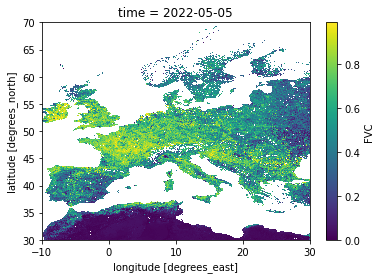

In [6]:
# Slice a desired part of NetCDF4 file
test_ds=test_ds.sel(lat=slice(30,70), lon=slice(-10, 30))

# Plot the slice
test_ds.FVC.plot()

# Close dataset to save the memory
test_ds.close()

### <a id='Second'></a>2. Calculating the FVC Anomaly

In order to calculate FVC anomaly for the desired locations, we first need to calculate climatology. We calculate average FVC values for the same day and location over a set number of years. In the next cell, we will specify a range of dates, for which we want to calculate the anomaly and a range of years, which will be used to calculate climatology.

Since EPS products are only available 3 times per month (1st, 5th and 25th of each month) we first construct a list of dates for the whole year and then filter out the unwanted dates.

In [7]:
# We can set start and end date using the following 2 variables:
start_date=dt.datetime(2022, 1, 1, 0, 0, 0)
end_date=dt.datetime(2022, 12, 31, 0, 0, 0)

# A list of days of interest is generated.
date_range=pd.date_range(start_date,end_date,freq='1d')

# Filter the daterange to only 5, 15, 25
date_range = date_range[(date_range.day == 5) | (date_range.day == 15) | (date_range.day == 25)]

#Define start and end of climatology
climatology_start=dt.datetime(2015,1,1)
climatology_end=dt.datetime(2021, 12, 31)

# Define a range of years for climatology
climatology_reference_years=pd.date_range(climatology_start, climatology_end, freq='1Y')

# Define empty arrays for results
product_values=np.full((locations_df.shape[0], len(date_range)), np.nan)
climatology_values=np.full((locations_df.shape[0], len(date_range)), np.nan)

We will use the function `get_data()` defined at the beginning of this JN to extract FVC values from locally stored ETFVC data. To access locally saved `NetCDF4` files we first need to specify the global variable `FILLES_LOCATION`, which is called inside the `get_data()` function. The `FILES_LOCATION` stores the path to the ET

In [8]:
FILLES_LOCATION="Data_EPS/"

We can use `get_data()` to access and plot FVC for the desired dates and locations and then save the results. To tackle the issue of potentially missing data the control of potential errors is advised. The `get_data()` will return the error if called `NetCDF4` file is missing, therefore it is recommended to use `try` and `except` with this function.

In some situations, it might be useful to print the missing files. As default the missing files are not printed, but this can be changed by setting the `ERROR_OUTPUT` to `True`.

In [9]:
ERROR_OUTPUT=False

We will show how to use the function `get_data()` in the next cell. We will iterate over all days of interest defined in the `date_range`. For each day, we get FVC values for all locations of interest in a single call of the function. We store the result in the `numpy.array` since it allows multidimensional indexing and therefore offers a fast way to directly save the output of the `get_data()` function.

The `try` and `except` commands are used in order to avoid interrupting the `for` loop in case of missing data. In case of exceptions, an error is printed if the `PRINT_ERROR` was set to `True`.

In [10]:
# Loop over datetime objects
for i, date in enumerate(date_range):

        for j in range(locations_df.shape[0]): 

                try:                      
                        product_values[[j], [i]]=get_data(date, "FVC", locations_df["lat"].iloc[j], locations_df["lon"].iloc[j])



                except Exception as e:
                        if ERROR_OUTPUT:
                                print(e)
                                print("Missing date"+str(date_range[i]))

We can do a quick visualization of the FVC values. The following code iterates over all locations defined at the beginning and plots FVC for each location over a specified date range. The plot is customized by adding a legend and setting labels, axes as well as a title.

Text(0.5, 1.0, 'Fractional Vegetation Cover (FVC) \n Range: [0, 1]')

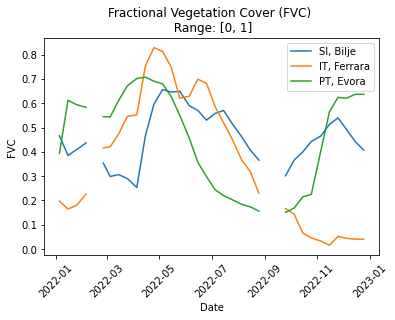

In [11]:
for j in range(locations_df.shape[0]):
    plt.plot(date_range.to_list(), product_values[j,:], label=locations_df["Name"].iloc[j])

plt.legend()
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("FVC")
plt.title("Fractional Vegetation Cover (FVC) \n Range: [0, 1]")

Now we will aslo calculate climatology wiht the help of `calculate_climatology()` function. We will iterate over the days of interest, for which we have already determined the FVC data. Similarly to before, the outputs are stored in a `numpy.array`.

In [12]:
# Loop over datetime objects
for i, date in enumerate(date_range):

        for j in range(locations_df.shape[0]):

                try:                      
                        climatology_values[[j], [i]]=calculate_climatology(date, "FVC", locations_df["lat"].iloc[j], locations_df["lon"].iloc[j])
        
                except Exception as e:
                       print(e)

In a similar manner as before with the FVC values, we may also visualize the reference.

The code iterates over all pre-defined locations and plots the FVC reference for each location. The plot that we obtain is further customized by adding a legend and setting labels for the x and y axis as well as a title.

Text(0.5, 1.0, 'Fractional Vegetation Cover (FVC) climatology \n Range: [0, 1]')

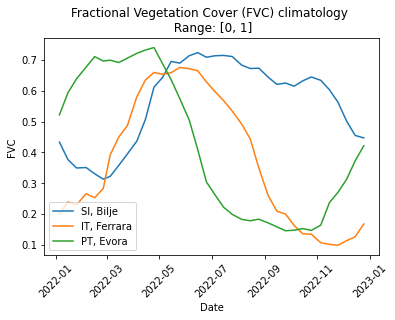

In [13]:
for j in range(locations_df.shape[0]):
    plt.plot(date_range.to_list(), climatology_values[j,:], label=locations_df["Name"].iloc[j])

plt.legend()
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("FVC")
plt.title("Fractional Vegetation Cover (FVC) climatology \n Range: [0, 1]")

### <a id='Third'></a>3. Plotting

We will plot the yearly FVC evolution in 2022 at three locations in the Mediterranean where drought occurred in 2022. Our hypothesis is that the drought will be evident in the form of lower FVC values compared to the reference that was based on multi-year dataset.

The code in the next cell plots FVC in 2022 at each location together with the corresponding reference for each location. Reference and FVC values for the same location are shown on the same subplot.

Code is designed in a way, that is able to accommodate additional locations by adding additional entries in `locations_df` dataset defined at the beginning of this notebook.

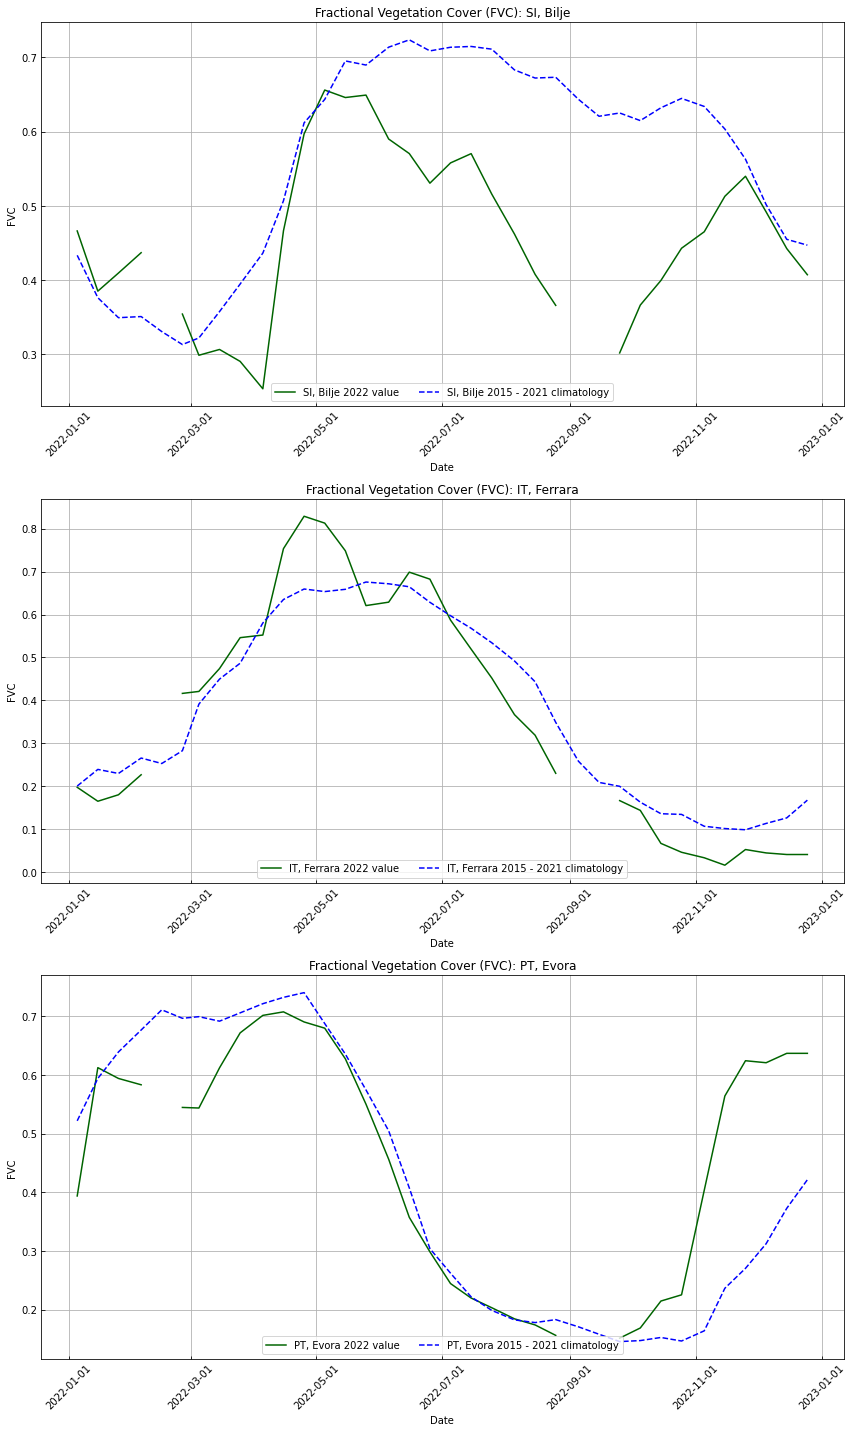

In [14]:
# Define figure and subplots
fig, ax = plt.subplots(locations_df.shape[0], 1, figsize=(12, 20))

# Flaten ax array, to simplify iteration
ax = ax.flatten()

# for loop over all locations:
for j in range(locations_df.shape[0]):

    # Plot data
    ax[j].plot(
        date_range.to_list(),
        product_values[j, :],
        label=locations_df["Name"].iloc[j] + " {} value".format(start_date.year),
        color="darkgreen",
        linestyle="solid",
    )

    # Plot climatology
    ax[j].plot(
        date_range.to_list(),
        climatology_values[j, :],
        label=locations_df["Name"].iloc[j]
        + " {} - {} climatology".format(climatology_start.year, climatology_end.year),
        color="blue",
        linestyle="dashed",
    )

    # Customize plot

    # Set ticks (major formatter must be used together with major locator)
    ax[j].tick_params(axis="both", direction="in")
    ticks = ax[j].get_xticks()
    ax[j].xaxis.set_major_locator(FixedLocator(ticks))
    ax[j].set_xticklabels(ticks, rotation=45)
    ax[j].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m-%d"))

    # Set legend and grid
    ax[j].legend(ncol=2, loc="lower center")
    ax[j].grid()

    # Set title
    ax[j].set_title(
        "Fractional Vegetation Cover (FVC): " + locations_df["Name"].iloc[j]
    )

    # Set labels
    ax[j].set_xlabel("Date")
    ax[j].set_ylabel("FVC")

# Tight layout to avoid overlaps of the subplots
plt.tight_layout()

In Bilje, Slovenia, a notable deviation from the reference (climatology) can be observed from May to September, which is in line with the drought in the southwestern region of Slovenia that occurred in 2022. This drought resulted in significant damage to agriculture. It was estimated to approximately [150 million EUR of damage in Slovenia alone](https://www.gov.si/assets/ministrstva/MF/Proracun-direktorat/DP-SSFLS/Navodila-obcinam/SklepVlade_Susa-2022.pdf).

A deviation from the reference values can be also observed in Evora in March and April 2022.

Contrary, one can not conclude just by looking at the plot, that FVC in Ferrara significantly deviated from the reference values.

#### Conclusion

We provide instructions on how to plot the LSA SAF ETFVC product for the selected locations. Furthermore, a reference is calculated for a specific period and compared to the FVC values recorded in 2022. A negative deviation of FVC from the reference values is observable in Bilje and Evora in 2022.

### References:

* array Developers (2023). xarray User Guide. [https://docs.xarray.dev/en/stable/user-guide/index.html](https://docs.xarray.dev/en/stable/user-guide/index.html). Accesed: 20.11.2023.